# RS evaluation with a custom response model

## Imports and preparations

In [1]:
%load_ext autoreload
%autoreload 2
# !pip install jupyter-black
%load_ext jupyter_black

In [2]:
import os
import sys

os.environ["JAVA_HOME"] = "/usr"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["OMP_NUM_THREADS"] = "32"
os.environ["NUMBA_NUM_THREADS"] = "4"

In [3]:
import random
import time
import scipy
import torch
import numpy as np
import pandas as pd
import warnings

from pyspark import SparkConf, StorageLevel
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from replay.models import UCB
from tqdm.auto import tqdm

from experiments.response_models.utils import plot_metric, calc_metric
from pyspark.sql.functions import col

In [4]:
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import Simulator
from sim4rec.response import BernoulliResponse, ActionModelTransformer


def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [5]:
# path to spark tmp folder and simulator checkpoints
SPARK_LOCAL_DIR = "./tmp/task_1"
CHECKPOINT_DIR = "./tmp/task_1_checkpoints"

In [6]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# simulator saves the interaction history between users and recommender system
# to rerun the simulation cycle or begin a new one, clear the directory or use another CHECKPOINT_DIR
rm -rf $1 $2

In [7]:
NUM_THREADS = 4

spark = (
    SparkSession.builder.appName("simulator")
    .master(f"local[{NUM_THREADS}]")
    .config("spark.sql.shuffle.partitions", f"{NUM_THREADS * 3}")
    .config("spark.default.parallelism", f"{NUM_THREADS * 3}")
    .config("spark.driver.memory", "4G")
    .config("spark.executor.memory", "4G")
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")
    .config("spark.local.dir", SPARK_LOCAL_DIR)
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

24/11/24 21:38:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 21:38:09 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [8]:
K = 10  # number of iterations
NUM_ITER = 10
SEED = 1234
np.random.seed(SEED)

## Data

### Load ContentWise in tabular form. Uncomment for the first run.

This preprocessing is similat to preprocessing in old `ContentWise` class: 
join interactions with impressions, binarize clicks, etc.

ContentWise consists of following files:
1. interactions.csv.gz:
    * `utc_ts_milliseconds` -- interaction timestamp  
    * `user_id` -- user id
    * `item_id`, `series_id` -- video id, video series id. As long as only series were recommended, we threat 'series' as primary items
    * `recommendation_id` -- key to match with recommendations
    * `episode_number`, `series_length`, `item_type`, `interaction_type`, `vision_factor`, `explicit_rating` are ignored

2. impressions-direct-link.csv.gz:
   * `recommendation_id` -- impression id to match with responses, `-1` for unknown recommendation
   * `recommendation_list_length`
   * `recommended_series_list` -- string representation of python list of series ids
   * `row_position` -- a position of recommendation slate on the site

In [9]:
# cw_impr = "data/ContentWiseImpressions/CW10M-CSV/impressions-direct-link.csv"
# impressions = spark.read.option("header", "true").csv(cw_impr)
# impressions = impressions.filter(col("recommendation_list_length") == K)
# impressions = impressions.withColumn(
#     "tmp", sf.regexp_replace("recommended_series_list", r"\[\s*", "")
# )
# impressions = impressions.withColumn("tmp", sf.regexp_replace("tmp", r"\s*\]", ""))
# impressions = impressions.withColumn("tmp", sf.regexp_replace("tmp", r"\s+", " "))
# impressions = impressions.withColumn("tmp", sf.split("tmp", " "))
# impressions = impressions.select(
#     "recommendation_id", sf.posexplode("tmp").alias("slate_pos", "item_id")
# ).drop("tmp", "recommendation_list_length", "recommended_series_list", "row_position")
# cw_inter = "data/ContentWiseImpressions/CW10M-CSV/interactions.csv"
# interactions = spark.read.option("header", "true").csv(cw_inter)
# interactions = interactions.filter(col("recommendation_id") != -1)
# interactions = interactions.drop(
#     "item_id",
#     "episode_number",
#     "series_length",
#     "item_type",
#     "interaction_type",
#     "vision_factor",
#     "explicit_rating",
# )
# interactions = interactions.withColumnRenamed("series_id", "item_id")

# recommendation_metadata = interactions.groupBy("recommendation_id").agg(
#     sf.min("utc_ts_milliseconds").alias("recommendation_timestamp"),
#     sf.first("user_id").alias("user_id"),
# )
# # click om item = first click on item
# interactions = interactions.drop("user_id")
# interactions = interactions.groupBy("recommendation_id", "item_id").agg(
#     sf.min("utc_ts_milliseconds").alias("response_timestamp")
# )
# # add response
# interactions = interactions.withColumn("response", sf.lit(1))
# content_wise_all = impressions.join(
#     interactions, how="left", on=["recommendation_id", "item_id"]
# ).join(recommendation_metadata, on="recommendation_id")
# content_wise_all = content_wise_all.withColumn(
#     "response", sf.coalesce("response", sf.lit(0))
# )

# # split train-val-test by global time:
# total_cnt = content_wise_all.count()
# train_cnt = int(0.6 * total_cnt)
# test_cnt = int(0.2 * total_cnt)
# val_cnt = int(0.2 * total_cnt)
# sorted_df = content_wise_all.orderBy("recommendation_timestamp")
# train = sorted_df.limit(train_cnt)
# val = sorted_df.subtract(train).limit(val_cnt)
# test = sorted_df.subtract(train).subtract(val)
# MAX_TIME = content_wise_all.agg(sf.max("recommendation_timestamp")).collect()[0][0]
# MAX_TIME

In [10]:
# def content_wise_to_simlog_format(df: "DataFrame"):
#     """Convert ContentWise dataset to math sim4rec log schema"""
#     df = df.drop("response_timestamp")
#     df = df.withColumn("response_proba", sf.col("response").cast("float"))
#     df = df.withColumnRenamed("item_id", "item_idx")
#     df = df.withColumnRenamed("user_id", "user_idx")
#     # place all historical interactions BEFORE the simulated
#     df = df.withColumn(
#         "__iter",
#         (sf.col("recommendation_timestamp").cast("bigint") - int(MAX_TIME)) / 1000,
#     ).drop("recommendation_timestamp", "recommendation_id")
#     return df


# train = content_wise_to_simlog_format(train)
# test = content_wise_to_simlog_format(test)
# val = content_wise_to_simlog_format(val)
# val.show(10)

In [11]:
# from sim4rec.response.nn_response import SIM_LOG_SCHEMA
# print(SIM_LOG_SCHEMA, train.schema)

# # cast types to match simlog schema
# train = train.withColumn("relevance", 1 / (sf.col("slate_pos") + 1))
# val = train.withColumn("relevance", 1 / (sf.col("slate_pos") + 1))
# test = train.withColumn("relevance", 1 / (sf.col("slate_pos") + 1))

# for field in SIM_LOG_SCHEMA:
#     train = train.withColumn(field.name, train[field.name].cast(field.dataType))
#     val = val.withColumn(field.name, val[field.name].cast(field.dataType))
#     test = test.withColumn(field.name, test[field.name].cast(field.dataType))

In [12]:
# # this takes some time
# !rm -rdf parquet && mkdir parquet
# train.write.partitionBy("user_idx").parquet("parquet/train")
# val.write.partitionBy("user_idx").parquet("parquet/val")
# test.write.partitionBy("user_idx").parquet("parquet/test")

In [13]:
# re-read:
train = spark.read.parquet("../parquet/train")
val = spark.read.parquet("../parquet/val")
test = spark.read.parquet("../parquet/test")

In [14]:
train.show(10)

+--------+---------+--------+--------------+--------+-------------------+--------+
|item_idx|slate_pos|response|response_proba|  __iter|          relevance|user_idx|
+--------+---------+--------+--------------+--------+-------------------+--------+
|   25508|        0|       0|           0.0|-8211853|                1.0|   35783|
|    9245|        8|       0|           0.0|-8211853| 0.1111111111111111|   35783|
|    5368|        6|       1|           1.0|-8211853|0.14285714285714285|   35783|
|    5939|        4|       0|           0.0|-8211853|                0.2|   35783|
|   10685|        5|       0|           0.0|-8211853|0.16666666666666666|   35783|
|   21058|        3|       0|           0.0|-8211853|               0.25|   35783|
|    5018|        9|       0|           0.0|-8211853|                0.1|   35783|
|   22613|        7|       0|           0.0|-8211853|              0.125|   35783|
|   17175|        2|       0|           0.0|-8211853| 0.3333333333333333|   35783|
|   

In [15]:
users = [
    [int(row["user_idx"])] for row in train.select("user_idx").distinct().collect()
]
NUM_USERS = len(users)
users = spark.createDataFrame(users, schema=["user_idx"])

items = [
    [int(row["item_idx"])] for row in train.select("item_idx").distinct().collect()
]
NUM_ITEMS = len(items)
items = spark.createDataFrame(items, schema=["item_idx"])

NUM_ITEMS, NUM_USERS

(2658, 19205)

In [16]:
item_generator = RealDataGenerator(label="items_real", seed=SEED)
user_generator = RealDataGenerator(label="users_real", seed=SEED)

item_generator.fit(items)
user_generator.fit(users)

item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)
item_generator.getDataSize()

2658

# One iteration of simulation cycle step by step

## (1) Choise of users

In [17]:
user_generator.sample(0.1).count()

1964

## (2) Choise of items
During the simulation cycle all 5276 items will be available at each iteration.

## (3) Initialization of recommender model

### Baseline

In [18]:
# RePlay model should be fitted on historic data before it can be refitted in cycle
# Let's assume we had one interaction for simplicity
model = UCB(sample=True, seed=SEED, exploration_coef=0.1)
model.fit(
    log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1))
)
pred = model.predict(log=None, users=users.limit(2), items=items, k=2)
pred.toPandas()

,user_idx,item_idx,relevance
0,232,16330,0.000376
1,232,17915,0.000376
2,23288,17599,0.000376
3,23288,14627,0.000376


The response function in this tutorial is very simple. The response is binary, response == 1 means the user bought the item.  
The probability of response is one tenth of the last digit of an `item_idx`. The response function is constant over time.

Response function gets dataframe with columns `user_idx`, `item_idx`, `relevance`, and returns dataframe with columns `user_idx`, `item_idx`, `relevance`, `response`, adding the response column to the initial ones. If the initial dataframe had some other columns, these will also be returned.

Example how the response is generated for user-item pair

## (4) Neural response function

In [19]:
from sim4rec.response import NNResponseEstimator, NNResponseTransformer

proba_model = NNResponseEstimator(
    outputCol="response_proba",
    log_dir=f"{CHECKPOINT_DIR}/pipeline",
    model_name="SlatewiseTransformer",
    hist_data_dir="../parquet/train",
    val_data_dir="../parquet/val",
    batch_size=256,
    lr=1e-3,
    num_epochs=5,
)

In [20]:
torch.__version__

'1.9.1+cu102'

In [21]:
# Fit and train NN response function, save checkpoint to the disk

proba_model = proba_model.fit(train)
!rm -rdf response_function_checkpoint
proba_model.save("response_function_checkpoint")

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

evaluate::   0%|          | 0/76 [00:00<?, ?it/s]

metrics(rocauc=tensor(0.5021), f1=tensor(0.1555), accuracy=tensor(0.6724))


train epoch::   0%|          | 0/76 [00:00<?, ?it/s]

evaluate::   0%|          | 0/76 [00:00<?, ?it/s]

metrics(rocauc=tensor(0.6201), f1=tensor(0.2110), accuracy=tensor(0.2747))


train epoch::   0%|          | 0/76 [00:00<?, ?it/s]

evaluate::   0%|          | 0/76 [00:00<?, ?it/s]

metrics(rocauc=tensor(0.6472), f1=tensor(0.2158), accuracy=tensor(0.2727))


train epoch::   0%|          | 0/76 [00:00<?, ?it/s]

evaluate::   0%|          | 0/76 [00:00<?, ?it/s]

metrics(rocauc=tensor(0.7152), f1=tensor(0.2459), accuracy=tensor(0.8811))


train epoch::   0%|          | 0/76 [00:00<?, ?it/s]

evaluate::   0%|          | 0/76 [00:00<?, ?it/s]

metrics(rocauc=tensor(0.7275), f1=tensor(0.2512), accuracy=tensor(0.4530))


train epoch::   0%|          | 0/76 [00:00<?, ?it/s]

evaluate::   0%|          | 0/76 [00:00<?, ?it/s]

metrics(rocauc=tensor(0.7352), f1=tensor(0.2665), accuracy=tensor(0.8777))


In [22]:
# reload saved response model
proba_model = NNResponseTransformer.load("response_function_checkpoint")

In [23]:
# create simlog dir (naturally it is created within the simulator pipeline)
!mkdir -p /root/notebooks/tmp/task_1_checkpoints/pipeline

In [25]:
test_response = proba_model.transform(pred)
test_response.show()

+--------+--------+--------------------+-------------------+
|user_idx|item_idx|           relevance|     response_proba|
+--------+--------+--------------------+-------------------+
|   23288|   17599|3.762227238525207E-4|0.19280970096588135|
|   23288|   14627|3.762227238525207E-4| 0.1980724036693573|
|     232|   16330|3.762227238525207E-4| 0.1340920478105545|
|     232|   17915|3.762227238525207E-4|0.07575525343418121|
+--------+--------+--------------------+-------------------+



### Pipelines work as well

In [26]:
br = BernoulliResponse(inputCol="response_proba", outputCol="response", seed=SEED)
response_pipeline = Pipeline(stages=[proba_model, br])
response_pipeline = response_pipeline.fit(items)

In [27]:
test_response = response_pipeline.transform(pred)

In [28]:
test_response.toPandas()

,user_idx,item_idx,relevance,response_proba,response
0,23288,17599,0.000376,0.192810,0
1,23288,14627,0.000376,0.198072,0
2,232,16330,0.000376,0.134092,0
3,232,17915,0.000376,0.075755,0


## (5) Fitting of new recommender model

After receiving responses to recommendations, we can use this information to update the recommender model. To do this, we should rename column `response` to `relevance`.

In [29]:
new_log = test_response.drop("relevance", "response_proba").withColumnRenamed(
    "response", "relevance"
)
new_log.limit(5).toPandas()

,user_idx,item_idx,relevance
0,23288,17599,0
1,23288,14627,0
2,232,16330,0
3,232,17915,0


In [30]:
model.fit(log=new_log)
model.item_popularity.limit(5).toPandas()

,item_idx,relevance
0,16330,0.37233
1,17915,0.37233
2,14627,0.37233
3,17599,0.37233


## (6) Quality of recommendations

Quality is the mean number of positive responses per user.

In [31]:
calc_metric(test_response)

0.0

# Training the model in the simulator

In [32]:
%%bash -s "$CHECKPOINT_DIR"
rm -rf $1

## Simulator initialization

In [33]:
user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    data_dir=f"{CHECKPOINT_DIR}/pipeline",
    user_key_col="user_idx",
    item_key_col="item_idx",
    spark_session=spark,
)

### Check that the format is correct

In [34]:
pred = model.predict(log=None, users=users.limit(10), items=items, k=K)

assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert (
    pred.groupBy("user_idx")
    .agg(sf.countDistinct("item_idx").alias("num_items"))
    .filter(sf.col("num_items") == sf.lit(K))
    .count()
    == 10
)
assert (
    pred.groupBy("user_idx")
    .agg(sf.count("item_idx").alias("num_items"))
    .filter(sf.col("num_items") == sf.lit(K))
    .count()
    == 10
)

In [35]:
log = sim.get_log(users)

## Response function initialization

In [36]:
proba_model = NNResponseTransformer.load("response_function_checkpoint")
br = BernoulliResponse(inputCol="response_proba", outputCol="response", seed=SEED)
response_pipeline = Pipeline(stages=[proba_model, br])
response_model = response_pipeline.fit(items)

## Simulation cycle

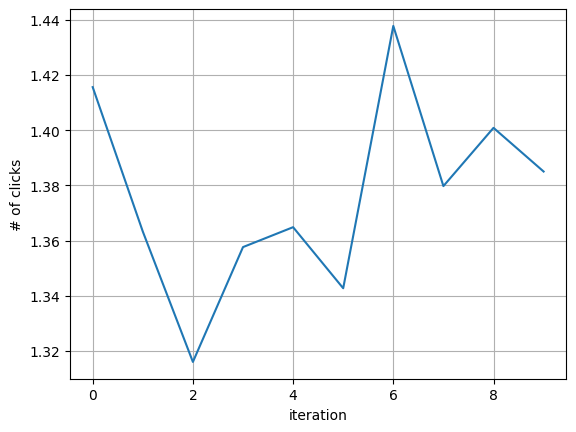

Iteration 9 finished in 72.66888523101807 sec.


In [37]:
metrics = []
# sim.update_log(spark.createDataFrame([], schema=SIM_LOG_SCHEMA), iteration=-1)

for i in range(NUM_ITER):
    print(f"Iteration {i} started")
    iter_time = time.time()
    # visiting users
    current_users = sim.sample_users(0.05).cache()
    user_idx = current_users.select("user_idx").rdd.flatMap(lambda x: x).collect()

    log = sim.get_log(users)
    recs = model.predict(
        log=log, k=K, users=current_users, items=items, filter_seen_items=False
    )
    # getting responses
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=response_model,
    )
    # update the interaction history
    sim.update_log(true_resp, iteration=i)
    # measure quality
    metrics.append(calc_metric(true_resp))
    # refitting the model
    model._clear_cache()
    train_log = sim.log
    model.fit(
        log=train_log.select("user_idx", "item_idx", "response").withColumnRenamed(
            "response", "relevance"
        )
    )

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    plot_metric(metrics)
    print(f"Iteration {i} finished in {time.time() - iter_time} sec.")

In [38]:
sim.log.filter(sf.col("__iter") == 1).filter(sf.col("response_proba") > 0.2).show(5)

+--------+--------+--------------------+-------------------+--------+------+
|item_idx|user_idx|           relevance|     response_proba|response|__iter|
+--------+--------+--------------------+-------------------+--------+------+
|    4743|      90|8.490598951946013E-4|0.23457157611846924|       1|     1|
|    2483|      90|5.957144256105823E-4|0.24364517629146576|       1|     1|
|    4641|      90|4.484400617341632E-4|0.23488779366016388|       1|     1|
|    3372|      90|4.484400617341632E-4| 0.2816031575202942|       0|     1|
|   25689|      90|3.178713280692018...| 0.2057647705078125|       0|     1|
+--------+--------+--------------------+-------------------+--------+------+
only showing top 5 rows



# Final prediction

In [39]:
recs = model.predict(
    log=sim.log, k=K, users=users, items=items, filter_seen_items=False
).cache()

In [ ]:
# responses
true_resp = sim.sample_responses(
    recs_df=recs,
    user_features=users,
    item_features=items,
    action_models=response_model,
).cache()

# quality
print(
    f"Average number of items purchased per user after model training = {calc_metric(true_resp)}"
)